# FEV vs. Semanticity Analysis

For each VGG19 layer, this notebook plots **mean FEV** vs. **silhouette score**.

- **Mean FEV** is taken from the regression: VGG19 features (reduced to N PCs) → Neural data (original dimensionality)

- For each layer, we select the **best FEV** (i.e., highest across PC counts)
  
- Silhouette score is calculated from TSNE-transformed, PCA-reduced VGG19 features. The number of PCs used is normalised across layers

- VGG19 features are extracted from 1,000 images from the STL10 dataset (10 classes, 100 images per class)

In [1]:
from cortexlib.stl10 import STL10FewShotDataset
from cortexlib.vgg19 import PreTrainedVGG19Model, PoolingMode
from cortexlib.tsne import TSNEVisualizer
from cortexlib.utils.file import read_json_file_as_dataframe, write_json_file
from cortexlib.utils.plotting import vgg19_colours
from cortexlib.utils.logging import Logger
import matplotlib.pyplot as plt
from adjustText import adjust_text
import pandas as pd

logger = Logger()

In [2]:
results = read_json_file_as_dataframe('./prediction.json')
best_fev_per_layer = results.loc[results.groupby("layer")["mean_fev"].idxmax()]

best_fev_per_layer

,layer,n_pcs,test_r2,mean_fev
0,conv2_2,NaN,0.012968,0.088767
9,conv3_4,100.0,0.012047,0.082980
10,conv4_4,NaN,0.011352,0.104368
15,conv5_4,NaN,0.008218,0.080550
20,fc2,NaN,0.006127,0.079454


In [4]:
vgg19 = PreTrainedVGG19Model(pooling_mode=PoolingMode.AVGPOOL)

settings = vgg19.get_image_settings()

logger.progress("Loading STL10 images")
stl10 = STL10FewShotDataset(
    n_per_class=100, 
    size=settings['size'],
    channels=settings['channels'],
    normalise_mean=settings['mean'], 
    normalise_std=settings['std'],
)
logger.success("Loaded STL10 images")

/Users/callummessiter/workspace/msc-neuro/research-project/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/callummessiter/workspace/msc-neuro/research-project/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
17:58:55 | INFO     | ⏳ Loading STL10 images...


Files already downloaded and verified
Files already downloaded and verified


17:59:10 | SUCCESS  | ✅ Loaded STL10 images!


In [8]:
logger.progress("VGG19: extracting features from STL10 images")
vgg19_feats, labels = vgg19.extract_features_with_pooling(stl10.dataset)
logger.success("VGG19 features extracted")

for layer, feats in vgg19_feats.items():
    logger.info(f"{layer} feats shape: {tuple(feats.shape)}")

18:04:43 | INFO     | ⏳ VGG19: extracting features from STL10 images...


  0%|          | 0/63 [00:00<?, ?it/s]

18:07:02 | SUCCESS  | ✅ VGG19 features extracted!
18:07:02 | INFO     | ℹ️ conv2_2 feats shape: (1000, 128)
18:07:02 | INFO     | ℹ️ conv3_4 feats shape: (1000, 256)
18:07:02 | INFO     | ℹ️ conv4_4 feats shape: (1000, 512)
18:07:02 | INFO     | ℹ️ conv5_4 feats shape: (1000, 512)
18:07:02 | INFO     | ℹ️ fc2 feats shape: (1000, 4096)


In [9]:
# Map each label to its corresponding class name
class_labels = [stl10.class_names[label] for label in labels]

tsne_visualiser = TSNEVisualizer()

logger.progress("Computing TSNE features from VGG19 features")
tsne_feats = tsne_visualiser.compute_tsne(vgg19_feats, n_pca_components=50)
logger.success("TSNE features computed")

silhouette_scores = tsne_visualiser.compute_silhouette_scores(tsne_feats, class_labels)

18:07:04 | INFO     | ⏳ Computing TSNE features from VGG19 features...
18:07:16 | SUCCESS  | ✅ TSNE features computed!


In [10]:
# json.dump() cannot serialize NumPy float32 types; convert to native Python floats first
silhouette_scores = {k: float(v) for k, v in silhouette_scores.items()}
write_json_file(silhouette_scores, './semanticity.json')

In [11]:
silhouette_df = pd.DataFrame(list(silhouette_scores.items()), columns=['layer', 'silhouette_score'])
silhouette_df

,layer,silhouette_score
0,conv2_2,-0.087484
1,conv3_4,-0.061713
2,conv4_4,0.006110
3,conv5_4,0.264032
4,fc2,0.461334


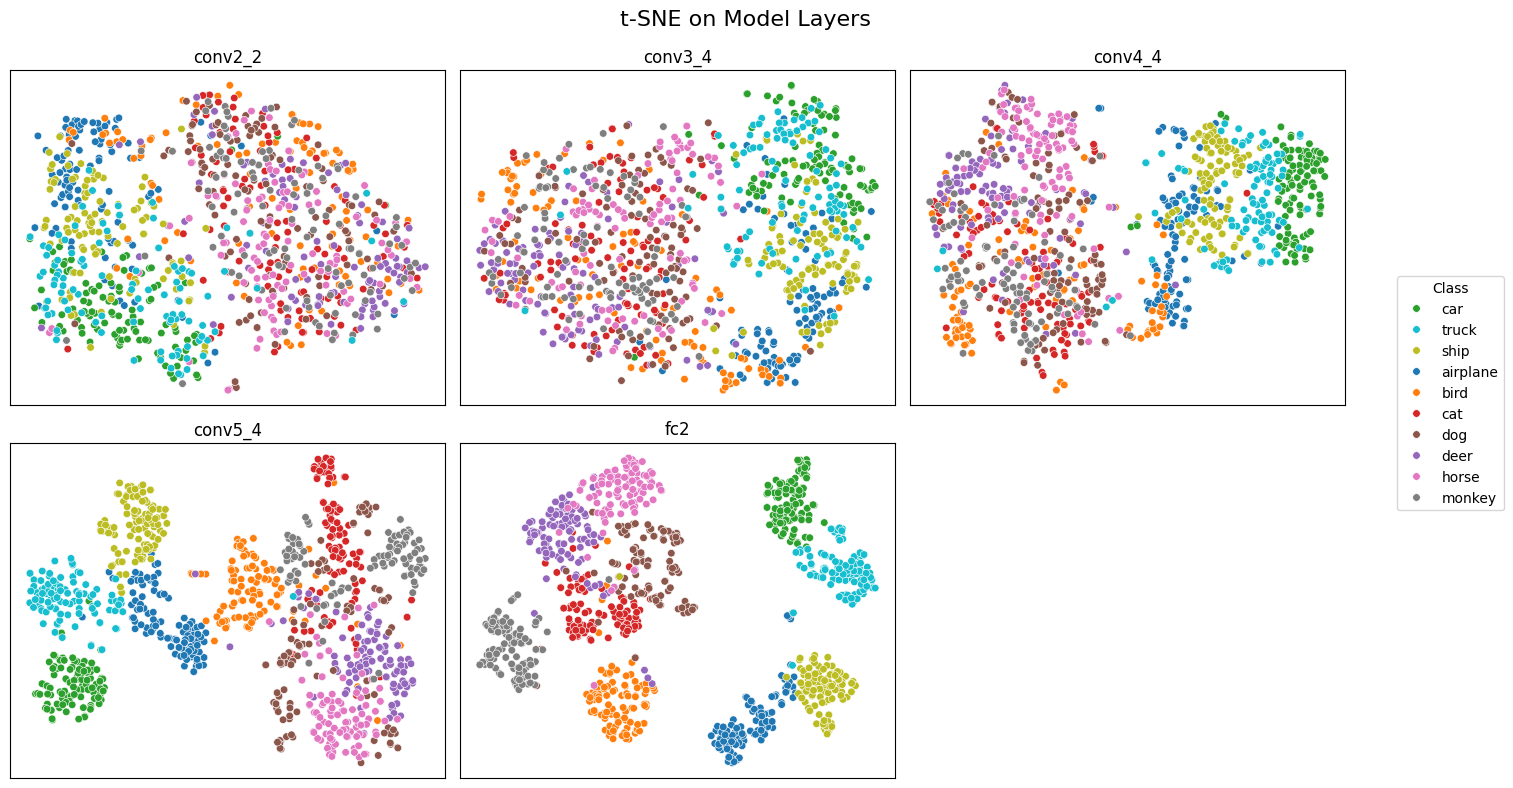

In [12]:
ordered_class_names = ['car', 'truck', 'ship', 'airplane', 'bird', 'cat',
                       'dog', 'deer', 'horse', 'monkey']

tsne_visualiser.plot_clusters_all_layers(tsne_feats, class_labels, custom_legend_order=ordered_class_names)

In [15]:
merged_results = pd.merge(best_fev_per_layer, silhouette_df, on='layer')
merged_results

,layer,n_pcs,test_r2,mean_fev,silhouette_score
0,conv2_2,NaN,0.012968,0.088767,-0.087484
1,conv3_4,100.0,0.012047,0.082980,-0.061713
2,conv4_4,NaN,0.011352,0.104368,0.006110
3,conv5_4,NaN,0.008218,0.080550,0.264032
4,fc2,NaN,0.006127,0.079454,0.461334


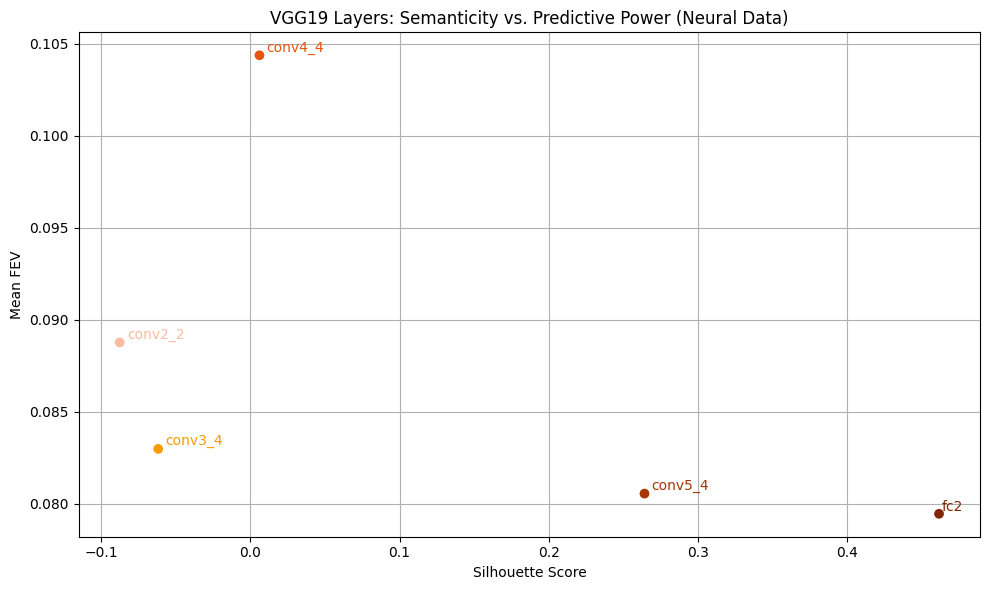

In [17]:
colours = merged_results['layer'].map(vgg19_colours)

plt.figure(figsize=(10, 6))
plt.scatter(merged_results['silhouette_score'], merged_results['mean_fev'], c=colours)

texts = []
for _, row in merged_results.iterrows():
    texts.append(
        plt.text(row['silhouette_score'], row['mean_fev'], row['layer'],
                 color=vgg19_colours[row['layer']], fontsize=10)
        )            

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray'))

plt.xlabel('Silhouette Score')
plt.ylabel('Mean FEV')
plt.title('VGG19 Layers: Semanticity vs. Predictive Power (Neural Data)')
plt.grid(True)
plt.tight_layout()
plt.show()